In [1]:
using Agents
using Random
using InteractiveDynamics
using CairoMakie

@agent tcell ContinuousAgent{2} begin
    activation_status::Float64
    has_been_activated::Bool
    time_after_activation::Int
end

@agent dcell ContinuousAgent{2} begin
        activation_status::Float64
        time_after_activation::Int
        has_been_activated::Bool
end

In [2]:
cells = Union{tcell, dcell}

function initialize_model(; 
    n_dcell = 30, 
    n_tcell = 40, 
    speed = 2,
    extent = (300,300),    
    visual_distance = 5.0,
    activation_status = 0.0,
     has_been_activated = false,
    time_after_activation = 0
    )

    space2d = ContinuousSpace(extent; spacing = 10,)
    
    model = ABM(cells, space2d ,rng = MersenneTwister(30),properties = Dict(:dt => 1.0); 
        scheduler = Schedulers.randomly)

    #scale the random number
    
    for _ in 1:n_tcell
        pos = Tuple(rand(model.rng, 2)).*300
        vel = sincos(2π * rand(model.rng)) .* speed 
        add_agent!(
            pos, tcell, model , vel, activation_status, has_been_activated, time_after_activation
        )
    end
    
    for _ in 1:n_dcell
        pos = Tuple(rand(model.rng, 2)).*300
        vel = sincos(2π * rand(model.rng)) .* speed .* 0.6
        add_agent!(
            pos, dcell, model, vel, activation_status, has_been_activated, time_after_activation
        )
    end


    return model
end

initialize_model (generic function with 1 method)

In [3]:
model = initialize_model()

function agent_step!(cells,model;
        speed = 5,
       )
     
#     tcell.vel = sincos(2π * rand(model.rng)) .* speed 
#     dcell.vel = sincos(2π * rand(model.rng)) .* speed  .* 0.6
    
    if cells isa dcell
        cells.vel = sincos(2π * rand(model.rng)) .* speed .* 0.6
        neighbor_ids = nearby_ids(cells,model,5)
        
        for id in neighbor_ids
            neighbor = model[id]
            if neighbor isa tcell && neighbor.has_been_activated == false
#                 print(typeof(model[id])) 
                cells.vel = (0,0)
            end
        end
        
        
    else 
        cells.vel = sincos(2π * rand(model.rng)) .* speed 
        neighbor_ids = nearby_ids(cells,model,5)
    
      
        for id in neighbor_ids
            neighbor = model[id]
            if neighbor isa dcell && cells.has_been_activated == false
                   cells.has_been_activated = true
                   cells.vel = (0,0)
                   cells.activation_status += 1/240
                   cells.time_after_activation += 1
                    break
                
            elseif neighbor isa dcell && cells.has_been_activated == true &&cells.time_after_activation< 1440
                    cells.time_after_activation += 1
                    cells.vel = (0,0)
                    cells.activation_status += 1/240
                    break
                
            elseif cells.time_after_activation == 1440
                    cells.vel = sincos(2π * rand(model.rng)) .* speed 
                    cells.activation_status -= 1/60

                    break
                end          
        end
    end
    
    move_agent!(cells, model, model.dt)
end

CairoMakie.activate!()



┌ Warning: AgentType is not concrete. If your agent is parametrically typed, you're probably
│ seeing this warning because you gave `Agent` instead of `Agent{Float64}`
│ (for example) to this function. You can also create an instance of your agent
│ and pass it to this function. If you want to use `Union` types for mixed agent
│ models, you can silence this warning.
└ @ Agents /Users/kimchanghyeon/.julia/packages/Agents/JVXgR/src/core/model.jl:299


In [4]:
istcell(a) = a isa tcell
isdcell(a) = a isa dcell
temptemp(a) = a.has_been_activated == true

steps = 10000
adata = [(istcell,count),(isdcell,count), (temptemp, count)]
adf, mdf = run!(model, agent_step!, steps; adata)


(10001×4 DataFrame
   Row │ step   count_istcell  count_isdcell  count_temptemp 
       │ Int64  Int64          Int64          Int64          
───────┼─────────────────────────────────────────────────────
     1 │     0             40             30               0
     2 │     1             40             30               6
     3 │     2             40             30               9
     4 │     3             40             30               9
     5 │     4             40             30               9
     6 │     5             40             30               9
     7 │     6             40             30               9
     8 │     7             40             30               9
     9 │     8             40             30              10
    10 │     9             40             30              10
    11 │    10             40             30              11
   ⋮   │   ⋮          ⋮              ⋮              ⋮
  9992 │  9991             40             30              40
  9993 │ 

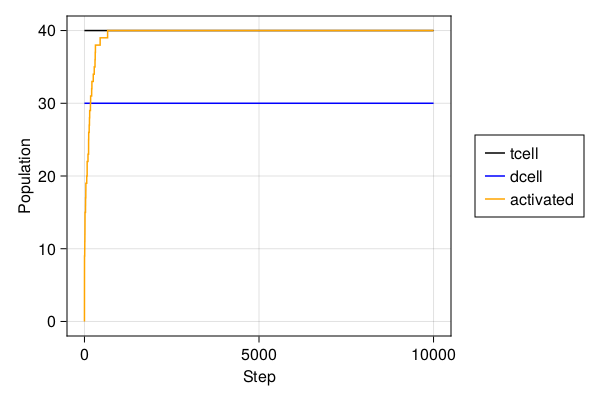

In [6]:
function plot_population(adf, mdf)
    figure = Figure(resolution = (600, 400))
    ax = figure[1, 1] = Axis(figure; xlabel = "Step", ylabel = "Population")
    tcell_l = lines!(ax, adf.step, adf.count_istcell, color = :black)
    dcell_l = lines!(ax, adf.step, adf.count_isdcell, color = :blue)
    activated_l = lines!(ax, adf.step, adf.count_temptemp, color = :orange)
    figure[1, 2] = Legend(figure, [tcell_l, dcell_l, activated_l], ["tcell","dcell","activated"])
    figure
end

plot_population(adf, mdf)
    

In [10]:
# offset(a) = a isa tcell ? (-0.1, -0.1*rand()) : (+0.1, +0.1*rand())
ashape(a) = :circle
asize(a) = a isa dcell ? 20 : 10
acolor(a) = a.activation_status > 0 ? :blue : :black
# ac(dcell) = :blue
# ac(tcell) = :black

acolor (generic function with 1 method)

In [5]:
abmvideo("tcell.mp4", model, agent_step!;
title = "immune cell", framerate  = 100, 
    frames = 2880, as=asize, am = ashape, ac = acolor)

In [ ]:
tcell dcell detach 될때 다시 값 감소 해서 색깔 바뀌는 것 구현

   